<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_different_generators_and_1_Classifier_ver8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

Using TensorFlow backend.


In [0]:
##!wget "https://github.com/rajagopalmotivate/DeepLearnIITMA1/blob/master/model2001s%20(1).h5"

In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

(60000, 28, 28)
(10000, 56, 56)


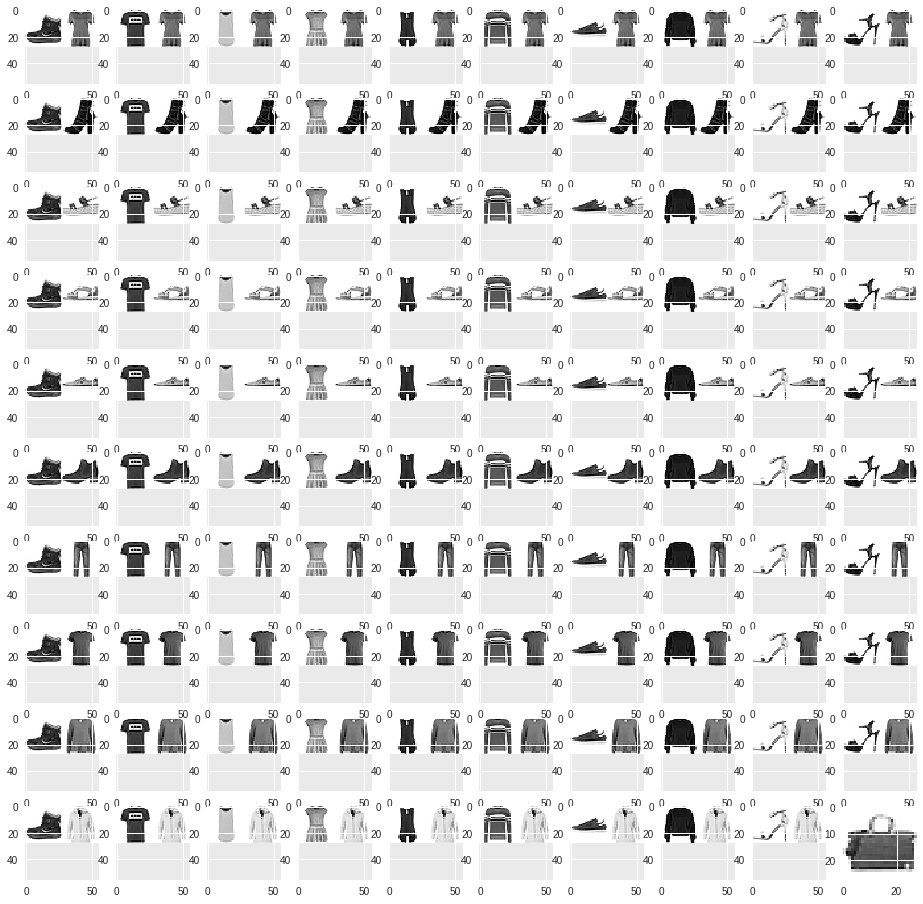

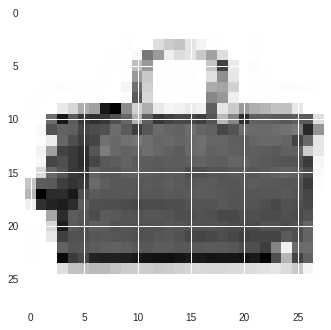

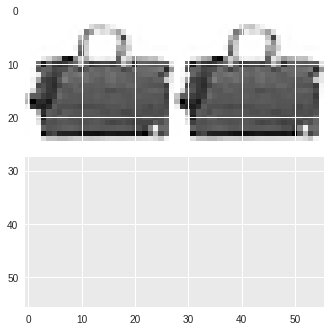

In [5]:
X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(1)

    num_examples = X_train.shape[0] / 5
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            else :
              fake_images = fake_images2
              fake_labels = fake_labels2
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNEW():
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
 ##   models = [generator1, generator2]
    models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [17]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW()


    
    

    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          

Number of examples:  12000.0
Number of Batches:  375
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/375 [D loss: 0.831215, acc.: 40.62%] [G loss: 0.804671]


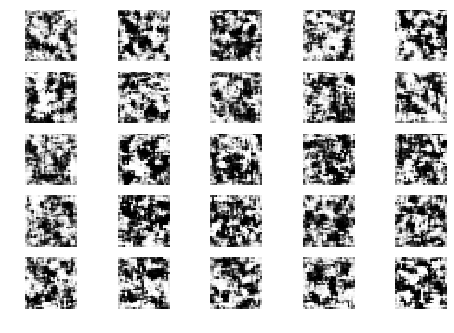

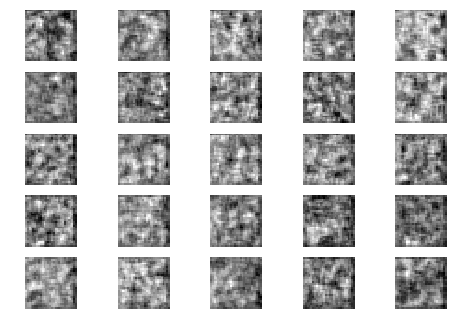

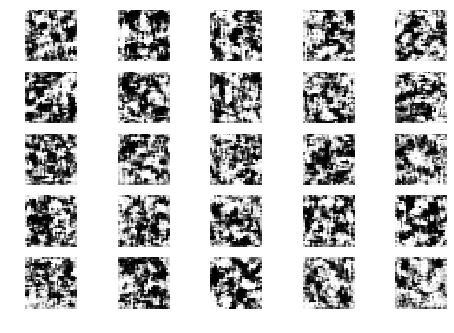

Epoch 0 Batch 1/375 [D loss: 0.659897, acc.: 68.75%] [G loss: 0.708256]
Epoch 0 Batch 2/375 [D loss: 0.571193, acc.: 71.88%] [G loss: 1.072587]
Epoch 0 Batch 3/375 [D loss: 0.522434, acc.: 68.75%] [G loss: 0.868092]
Epoch 0 Batch 4/375 [D loss: 0.428864, acc.: 81.25%] [G loss: 1.020840]
Epoch 0 Batch 5/375 [D loss: 0.382109, acc.: 87.50%] [G loss: 1.117973]
Epoch 0 Batch 6/375 [D loss: 0.307963, acc.: 87.50%] [G loss: 1.061949]
Epoch 0 Batch 7/375 [D loss: 0.252460, acc.: 100.00%] [G loss: 1.442257]
Epoch 0 Batch 8/375 [D loss: 0.322591, acc.: 84.38%] [G loss: 1.346993]
Epoch 0 Batch 9/375 [D loss: 0.371224, acc.: 81.25%] [G loss: 1.454204]
Epoch 0 Batch 10/375 [D loss: 0.334261, acc.: 87.50%] [G loss: 1.740755]
Epoch 0 Batch 11/375 [D loss: 0.328212, acc.: 90.62%] [G loss: 1.931541]
Epoch 0 Batch 12/375 [D loss: 0.339583, acc.: 84.38%] [G loss: 2.084001]
Epoch 0 Batch 13/375 [D loss: 0.348822, acc.: 87.50%] [G loss: 2.297423]
Epoch 0 Batch 14/375 [D loss: 0.326885, acc.: 84.38%] [G lo

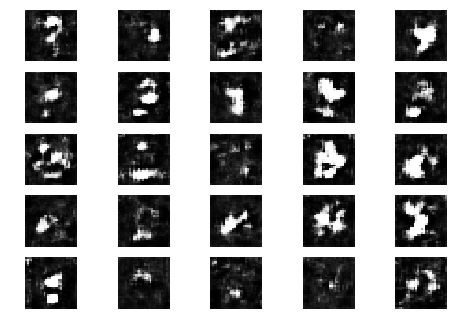

Epoch 0 Batch 101/375 [D loss: 0.532104, acc.: 68.75%] [G loss: 1.332729]


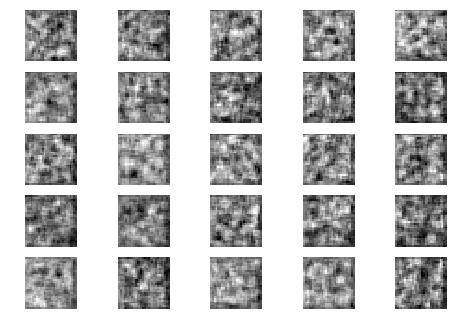

Epoch 0 Batch 102/375 [D loss: 1.019779, acc.: 46.88%] [G loss: 2.412929]


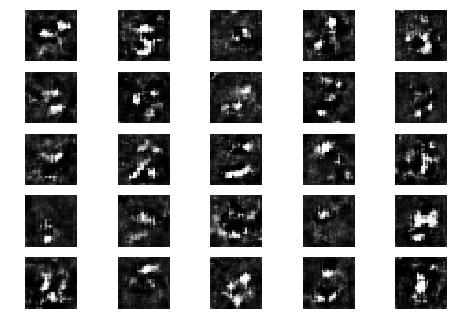

Epoch 0 Batch 103/375 [D loss: 0.906299, acc.: 46.88%] [G loss: 2.439752]
Epoch 0 Batch 104/375 [D loss: 1.177074, acc.: 50.00%] [G loss: 1.351247]
Epoch 0 Batch 105/375 [D loss: 0.796097, acc.: 59.38%] [G loss: 1.152224]
Epoch 0 Batch 106/375 [D loss: 0.656700, acc.: 62.50%] [G loss: 1.361879]
Epoch 0 Batch 107/375 [D loss: 0.602527, acc.: 75.00%] [G loss: 1.856659]
Epoch 0 Batch 108/375 [D loss: 0.610680, acc.: 68.75%] [G loss: 1.881585]
Epoch 0 Batch 109/375 [D loss: 0.727401, acc.: 56.25%] [G loss: 1.661184]
Epoch 0 Batch 110/375 [D loss: 0.638008, acc.: 68.75%] [G loss: 2.018479]
Epoch 0 Batch 111/375 [D loss: 0.538050, acc.: 71.88%] [G loss: 1.624679]
Epoch 0 Batch 112/375 [D loss: 0.843976, acc.: 53.12%] [G loss: 2.080691]
Epoch 0 Batch 113/375 [D loss: 0.693601, acc.: 62.50%] [G loss: 2.498989]
Epoch 0 Batch 114/375 [D loss: 1.268303, acc.: 50.00%] [G loss: 2.084669]
Epoch 0 Batch 115/375 [D loss: 0.929062, acc.: 46.88%] [G loss: 1.568640]
Epoch 0 Batch 116/375 [D loss: 0.71904

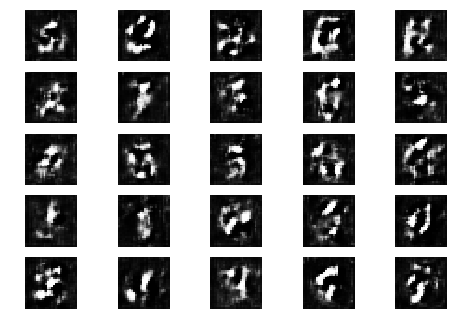

Epoch 0 Batch 201/375 [D loss: 0.722954, acc.: 65.62%] [G loss: 1.435288]
Epoch 0 Batch 202/375 [D loss: 0.880872, acc.: 56.25%] [G loss: 1.140385]


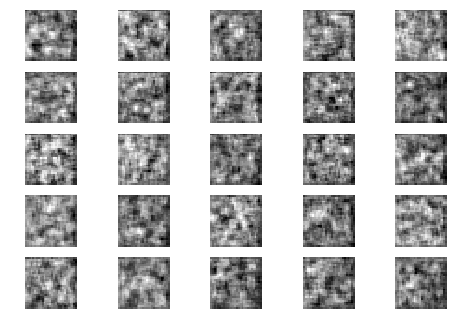

Epoch 0 Batch 203/375 [D loss: 0.881631, acc.: 53.12%] [G loss: 0.993305]
Epoch 0 Batch 204/375 [D loss: 0.581322, acc.: 71.88%] [G loss: 1.089836]


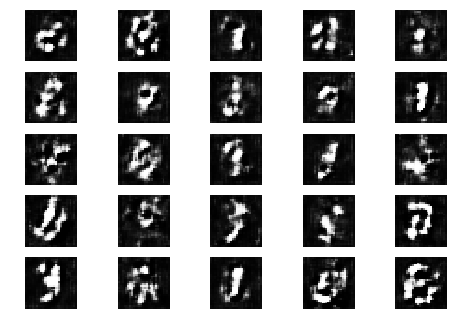

Epoch 0 Batch 205/375 [D loss: 0.666480, acc.: 62.50%] [G loss: 1.437475]
Epoch 0 Batch 206/375 [D loss: 0.614009, acc.: 68.75%] [G loss: 1.483038]
Epoch 0 Batch 207/375 [D loss: 0.914939, acc.: 37.50%] [G loss: 1.086762]
Epoch 0 Batch 208/375 [D loss: 0.801737, acc.: 56.25%] [G loss: 1.137199]
Epoch 0 Batch 209/375 [D loss: 0.906903, acc.: 40.62%] [G loss: 1.307644]
Epoch 0 Batch 210/375 [D loss: 0.659655, acc.: 68.75%] [G loss: 1.445751]
Epoch 0 Batch 211/375 [D loss: 0.841182, acc.: 53.12%] [G loss: 1.343220]
Epoch 0 Batch 212/375 [D loss: 0.789654, acc.: 56.25%] [G loss: 1.156729]
Epoch 0 Batch 213/375 [D loss: 0.840381, acc.: 62.50%] [G loss: 1.426170]
Epoch 0 Batch 214/375 [D loss: 1.281368, acc.: 28.12%] [G loss: 1.193855]
Epoch 0 Batch 215/375 [D loss: 1.064036, acc.: 31.25%] [G loss: 1.115542]
Epoch 0 Batch 216/375 [D loss: 0.850920, acc.: 43.75%] [G loss: 1.506948]
Epoch 0 Batch 217/375 [D loss: 0.701665, acc.: 59.38%] [G loss: 1.137690]
Epoch 0 Batch 218/375 [D loss: 0.86154

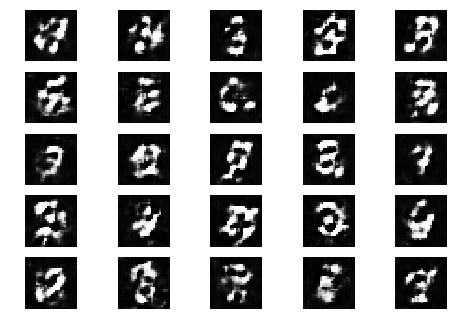

Epoch 0 Batch 301/375 [D loss: 0.854593, acc.: 34.38%] [G loss: 1.016432]
Epoch 0 Batch 302/375 [D loss: 0.615503, acc.: 59.38%] [G loss: 0.990757]
Epoch 0 Batch 303/375 [D loss: 0.709368, acc.: 59.38%] [G loss: 1.100896]


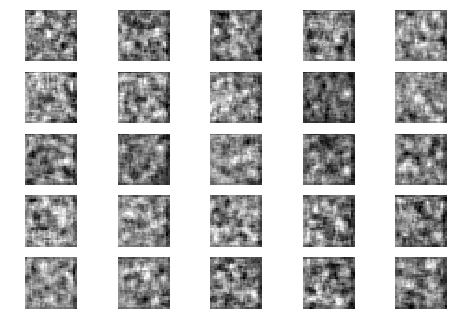

Epoch 0 Batch 304/375 [D loss: 0.678084, acc.: 65.62%] [G loss: 1.131094]
Epoch 0 Batch 305/375 [D loss: 0.675993, acc.: 62.50%] [G loss: 0.958860]
Epoch 0 Batch 306/375 [D loss: 0.558198, acc.: 75.00%] [G loss: 1.111257]


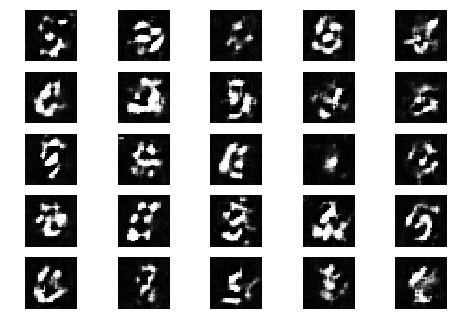

Epoch 0 Batch 307/375 [D loss: 0.689708, acc.: 62.50%] [G loss: 1.132840]
Epoch 0 Batch 308/375 [D loss: 0.716538, acc.: 56.25%] [G loss: 1.437672]
Epoch 0 Batch 309/375 [D loss: 0.701729, acc.: 62.50%] [G loss: 1.435906]
Epoch 0 Batch 310/375 [D loss: 0.866289, acc.: 50.00%] [G loss: 1.243619]
Epoch 0 Batch 311/375 [D loss: 0.816123, acc.: 50.00%] [G loss: 1.282241]
Epoch 0 Batch 312/375 [D loss: 0.614755, acc.: 53.12%] [G loss: 1.185248]
Epoch 0 Batch 313/375 [D loss: 0.842683, acc.: 43.75%] [G loss: 1.172372]
Epoch 0 Batch 314/375 [D loss: 0.718875, acc.: 56.25%] [G loss: 1.017808]
Epoch 0 Batch 315/375 [D loss: 0.814601, acc.: 50.00%] [G loss: 1.024727]
Epoch 0 Batch 316/375 [D loss: 0.752943, acc.: 59.38%] [G loss: 0.953515]
Epoch 0 Batch 317/375 [D loss: 0.771268, acc.: 53.12%] [G loss: 0.978083]
Epoch 0 Batch 318/375 [D loss: 0.701199, acc.: 62.50%] [G loss: 1.032814]
Epoch 0 Batch 319/375 [D loss: 0.662000, acc.: 59.38%] [G loss: 1.175977]
Epoch 0 Batch 320/375 [D loss: 0.69289

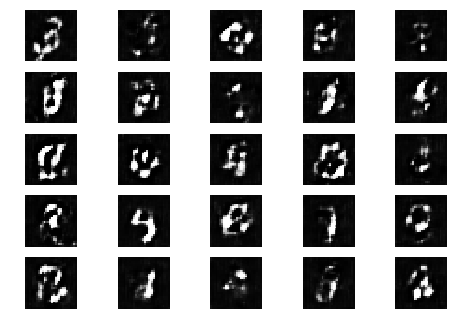

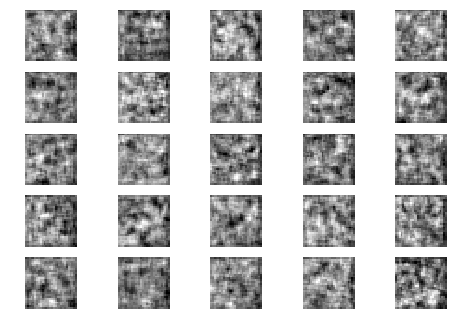

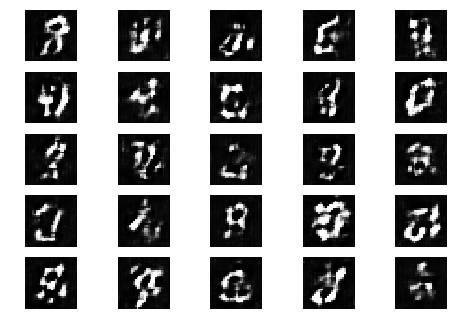

Epoch 1 Batch 1/375 [D loss: 0.635219, acc.: 68.75%] [G loss: 1.084523]
Epoch 1 Batch 2/375 [D loss: 0.744117, acc.: 59.38%] [G loss: 0.875429]
Epoch 1 Batch 3/375 [D loss: 0.734067, acc.: 43.75%] [G loss: 1.085887]
Epoch 1 Batch 4/375 [D loss: 0.706492, acc.: 65.62%] [G loss: 1.047598]
Epoch 1 Batch 5/375 [D loss: 0.696889, acc.: 62.50%] [G loss: 1.332447]
Epoch 1 Batch 6/375 [D loss: 0.736167, acc.: 53.12%] [G loss: 0.964063]
Epoch 1 Batch 7/375 [D loss: 0.763186, acc.: 46.88%] [G loss: 0.942466]
Epoch 1 Batch 8/375 [D loss: 0.701929, acc.: 68.75%] [G loss: 1.262254]
Epoch 1 Batch 9/375 [D loss: 0.770885, acc.: 46.88%] [G loss: 1.280623]
Epoch 1 Batch 10/375 [D loss: 0.624375, acc.: 68.75%] [G loss: 1.052239]
Epoch 1 Batch 11/375 [D loss: 0.724499, acc.: 53.12%] [G loss: 1.286875]
Epoch 1 Batch 12/375 [D loss: 0.783528, acc.: 50.00%] [G loss: 1.095807]
Epoch 1 Batch 13/375 [D loss: 0.627828, acc.: 71.88%] [G loss: 1.120448]
Epoch 1 Batch 14/375 [D loss: 0.689294, acc.: 71.88%] [G los

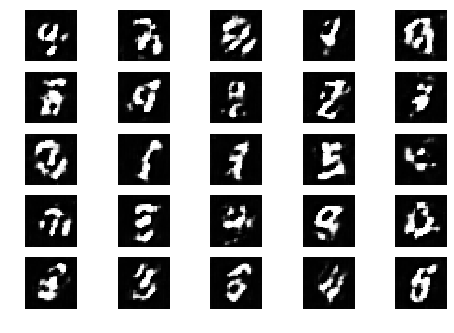

Epoch 1 Batch 101/375 [D loss: 0.731486, acc.: 62.50%] [G loss: 1.348133]


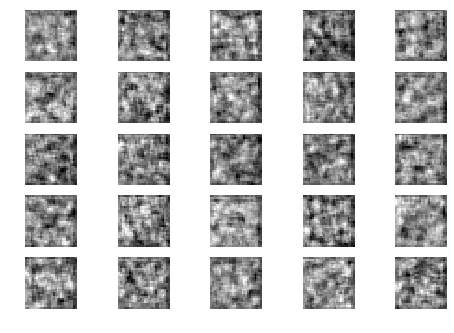

Epoch 1 Batch 102/375 [D loss: 0.801538, acc.: 56.25%] [G loss: 1.083772]


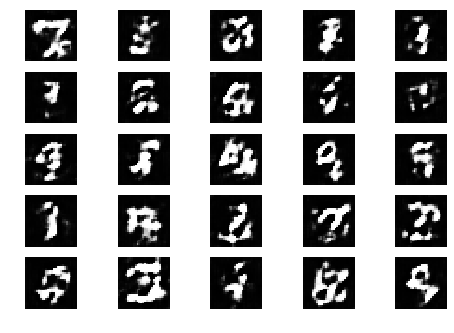

Epoch 1 Batch 103/375 [D loss: 0.771713, acc.: 50.00%] [G loss: 0.989215]
Epoch 1 Batch 104/375 [D loss: 0.748012, acc.: 50.00%] [G loss: 1.123103]
Epoch 1 Batch 105/375 [D loss: 0.737160, acc.: 46.88%] [G loss: 1.078118]
Epoch 1 Batch 106/375 [D loss: 0.647613, acc.: 53.12%] [G loss: 1.014015]
Epoch 1 Batch 107/375 [D loss: 0.691878, acc.: 53.12%] [G loss: 1.254690]
Epoch 1 Batch 108/375 [D loss: 0.786379, acc.: 46.88%] [G loss: 1.040075]
Epoch 1 Batch 109/375 [D loss: 0.731555, acc.: 59.38%] [G loss: 1.039900]
Epoch 1 Batch 110/375 [D loss: 0.679509, acc.: 56.25%] [G loss: 1.169573]
Epoch 1 Batch 111/375 [D loss: 1.054463, acc.: 25.00%] [G loss: 1.034717]
Epoch 1 Batch 112/375 [D loss: 0.568641, acc.: 71.88%] [G loss: 1.055551]
Epoch 1 Batch 113/375 [D loss: 0.687046, acc.: 68.75%] [G loss: 1.137399]
Epoch 1 Batch 114/375 [D loss: 0.808934, acc.: 53.12%] [G loss: 1.097047]
Epoch 1 Batch 115/375 [D loss: 0.672135, acc.: 62.50%] [G loss: 1.006355]
Epoch 1 Batch 116/375 [D loss: 0.81465

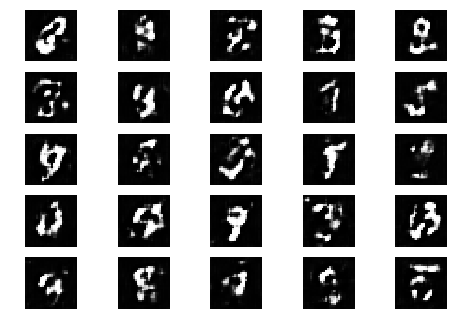

Epoch 1 Batch 201/375 [D loss: 0.691997, acc.: 56.25%] [G loss: 1.175370]
Epoch 1 Batch 202/375 [D loss: 0.626677, acc.: 62.50%] [G loss: 1.320382]


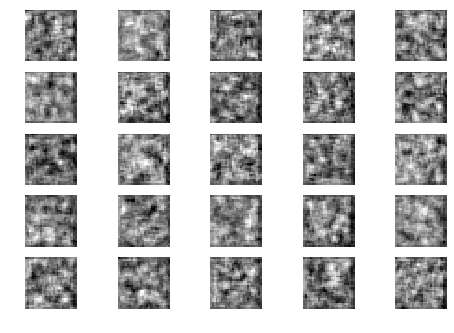

Epoch 1 Batch 203/375 [D loss: 0.794383, acc.: 50.00%] [G loss: 1.097805]
Epoch 1 Batch 204/375 [D loss: 0.653289, acc.: 65.62%] [G loss: 0.939005]


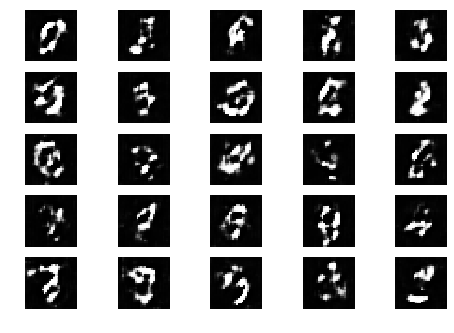

Epoch 1 Batch 205/375 [D loss: 0.787853, acc.: 43.75%] [G loss: 0.985442]
Epoch 1 Batch 206/375 [D loss: 0.639237, acc.: 68.75%] [G loss: 1.131501]
Epoch 1 Batch 207/375 [D loss: 0.537247, acc.: 75.00%] [G loss: 1.207600]
Epoch 1 Batch 208/375 [D loss: 0.703554, acc.: 56.25%] [G loss: 1.117338]
Epoch 1 Batch 209/375 [D loss: 0.609496, acc.: 65.62%] [G loss: 0.965689]
Epoch 1 Batch 210/375 [D loss: 0.606384, acc.: 65.62%] [G loss: 1.143812]
Epoch 1 Batch 211/375 [D loss: 0.690054, acc.: 59.38%] [G loss: 1.238929]
Epoch 1 Batch 212/375 [D loss: 0.636128, acc.: 71.88%] [G loss: 1.202544]
Epoch 1 Batch 213/375 [D loss: 0.638201, acc.: 62.50%] [G loss: 1.158752]
Epoch 1 Batch 214/375 [D loss: 0.677796, acc.: 59.38%] [G loss: 0.899317]
Epoch 1 Batch 215/375 [D loss: 0.821150, acc.: 46.88%] [G loss: 1.038850]
Epoch 1 Batch 216/375 [D loss: 0.774704, acc.: 46.88%] [G loss: 1.329846]
Epoch 1 Batch 217/375 [D loss: 0.563690, acc.: 68.75%] [G loss: 1.299988]
Epoch 1 Batch 218/375 [D loss: 0.72975

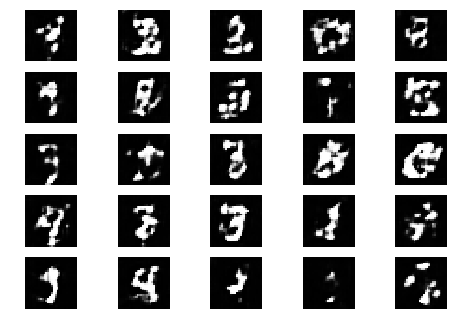

Epoch 1 Batch 301/375 [D loss: 0.891371, acc.: 37.50%] [G loss: 1.140585]
Epoch 1 Batch 302/375 [D loss: 0.543791, acc.: 71.88%] [G loss: 1.334562]
Epoch 1 Batch 303/375 [D loss: 0.575063, acc.: 65.62%] [G loss: 1.361818]


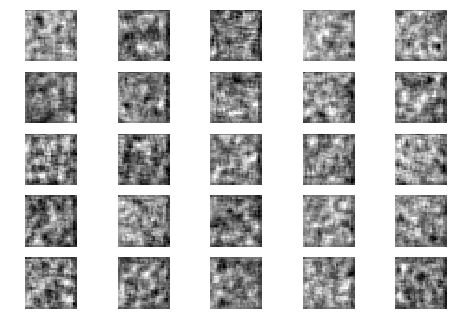

Epoch 1 Batch 304/375 [D loss: 0.723220, acc.: 56.25%] [G loss: 0.982386]
Epoch 1 Batch 305/375 [D loss: 0.776643, acc.: 53.12%] [G loss: 0.843286]
Epoch 1 Batch 306/375 [D loss: 0.776437, acc.: 50.00%] [G loss: 1.021226]


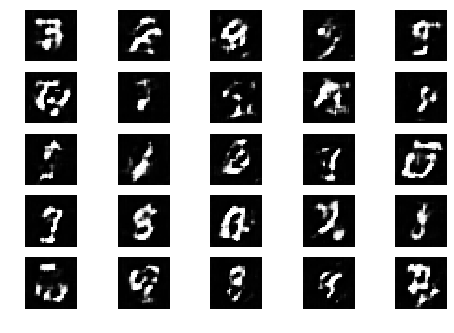

Epoch 1 Batch 307/375 [D loss: 0.597808, acc.: 75.00%] [G loss: 1.185356]
Epoch 1 Batch 308/375 [D loss: 0.763347, acc.: 53.12%] [G loss: 1.264562]
Epoch 1 Batch 309/375 [D loss: 0.614954, acc.: 62.50%] [G loss: 1.289763]
Epoch 1 Batch 310/375 [D loss: 0.545698, acc.: 78.12%] [G loss: 1.153493]
Epoch 1 Batch 311/375 [D loss: 0.699165, acc.: 56.25%] [G loss: 1.392709]
Epoch 1 Batch 312/375 [D loss: 0.794328, acc.: 53.12%] [G loss: 1.156931]
Epoch 1 Batch 313/375 [D loss: 0.687829, acc.: 59.38%] [G loss: 1.313548]
Epoch 1 Batch 314/375 [D loss: 0.569136, acc.: 71.88%] [G loss: 1.143751]
Epoch 1 Batch 315/375 [D loss: 0.626962, acc.: 65.62%] [G loss: 1.244200]
Epoch 1 Batch 316/375 [D loss: 0.655326, acc.: 56.25%] [G loss: 1.111854]
Epoch 1 Batch 317/375 [D loss: 0.692207, acc.: 65.62%] [G loss: 1.172727]
Epoch 1 Batch 318/375 [D loss: 0.685372, acc.: 62.50%] [G loss: 1.308482]
Epoch 1 Batch 319/375 [D loss: 0.678912, acc.: 59.38%] [G loss: 1.201294]
Epoch 1 Batch 320/375 [D loss: 0.58528

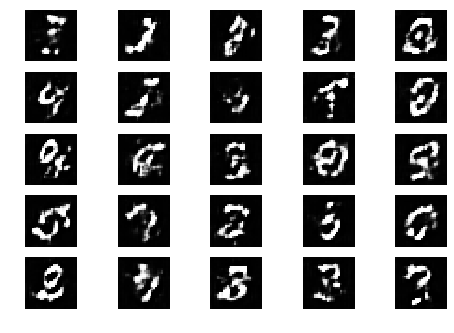

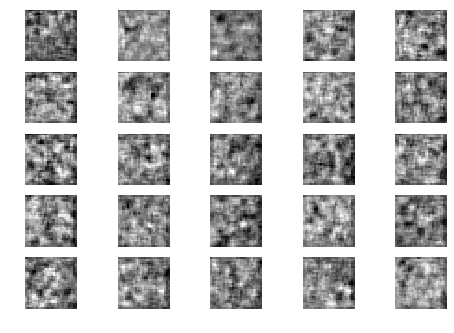

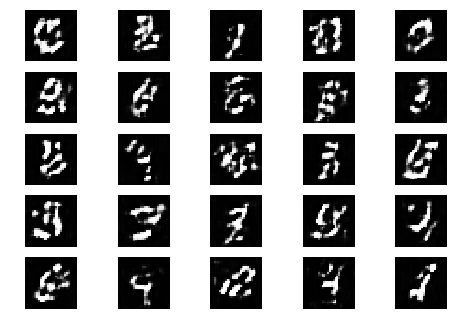

Epoch 2 Batch 1/375 [D loss: 0.634667, acc.: 71.88%] [G loss: 1.145009]
Epoch 2 Batch 2/375 [D loss: 0.628365, acc.: 62.50%] [G loss: 1.269350]
Epoch 2 Batch 3/375 [D loss: 0.716634, acc.: 59.38%] [G loss: 1.072925]
Epoch 2 Batch 4/375 [D loss: 0.478869, acc.: 81.25%] [G loss: 1.257025]
Epoch 2 Batch 5/375 [D loss: 0.699984, acc.: 56.25%] [G loss: 1.209534]
Epoch 2 Batch 6/375 [D loss: 0.828519, acc.: 56.25%] [G loss: 0.950799]
Epoch 2 Batch 7/375 [D loss: 0.598896, acc.: 62.50%] [G loss: 1.298239]
Epoch 2 Batch 8/375 [D loss: 0.535310, acc.: 75.00%] [G loss: 1.038241]
Epoch 2 Batch 9/375 [D loss: 0.711515, acc.: 53.12%] [G loss: 1.154763]
Epoch 2 Batch 10/375 [D loss: 0.527741, acc.: 65.62%] [G loss: 1.098797]
Epoch 2 Batch 11/375 [D loss: 0.631402, acc.: 65.62%] [G loss: 1.031622]
Epoch 2 Batch 12/375 [D loss: 0.682356, acc.: 56.25%] [G loss: 1.159761]
Epoch 2 Batch 13/375 [D loss: 0.712774, acc.: 65.62%] [G loss: 1.274412]
Epoch 2 Batch 14/375 [D loss: 0.639330, acc.: 59.38%] [G los

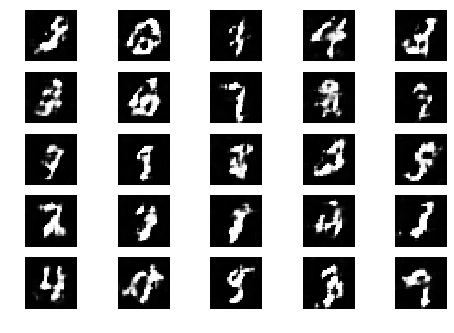

Epoch 2 Batch 101/375 [D loss: 0.738510, acc.: 62.50%] [G loss: 1.423028]


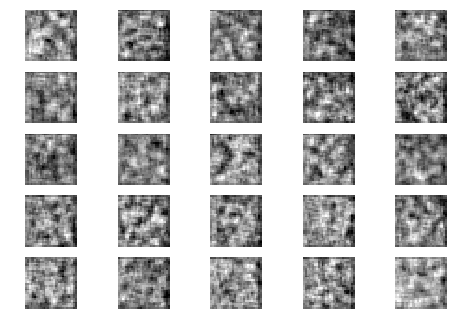

Epoch 2 Batch 102/375 [D loss: 0.612709, acc.: 56.25%] [G loss: 1.208528]


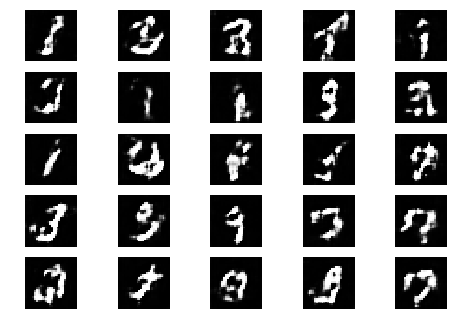

Epoch 2 Batch 103/375 [D loss: 0.804275, acc.: 50.00%] [G loss: 1.150033]
Epoch 2 Batch 104/375 [D loss: 0.591317, acc.: 68.75%] [G loss: 1.210964]
Epoch 2 Batch 105/375 [D loss: 0.618554, acc.: 65.62%] [G loss: 1.181056]
Epoch 2 Batch 106/375 [D loss: 0.472527, acc.: 81.25%] [G loss: 1.169273]
Epoch 2 Batch 107/375 [D loss: 0.563208, acc.: 75.00%] [G loss: 1.161662]
Epoch 2 Batch 108/375 [D loss: 0.659974, acc.: 62.50%] [G loss: 0.976892]
Epoch 2 Batch 109/375 [D loss: 0.588021, acc.: 71.88%] [G loss: 1.253254]
Epoch 2 Batch 110/375 [D loss: 0.551640, acc.: 71.88%] [G loss: 1.352937]
Epoch 2 Batch 111/375 [D loss: 0.807035, acc.: 50.00%] [G loss: 0.987582]
Epoch 2 Batch 112/375 [D loss: 0.691171, acc.: 56.25%] [G loss: 1.152030]
Epoch 2 Batch 113/375 [D loss: 0.770883, acc.: 53.12%] [G loss: 1.026977]
Epoch 2 Batch 114/375 [D loss: 0.617061, acc.: 62.50%] [G loss: 1.147051]
Epoch 2 Batch 115/375 [D loss: 0.549301, acc.: 71.88%] [G loss: 1.170361]
Epoch 2 Batch 116/375 [D loss: 0.52196

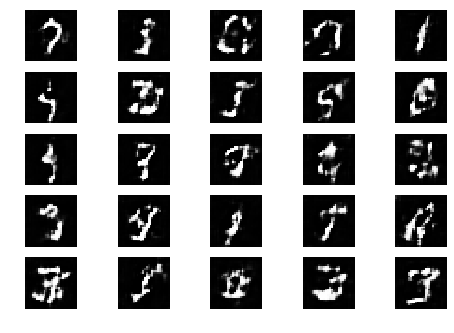

Epoch 2 Batch 201/375 [D loss: 0.696055, acc.: 62.50%] [G loss: 1.253214]
Epoch 2 Batch 202/375 [D loss: 0.489430, acc.: 81.25%] [G loss: 1.287339]


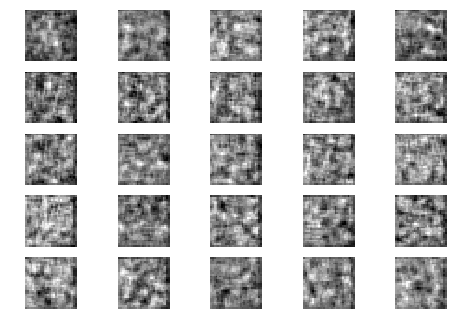

Epoch 2 Batch 203/375 [D loss: 0.593892, acc.: 62.50%] [G loss: 1.218102]
Epoch 2 Batch 204/375 [D loss: 0.765803, acc.: 53.12%] [G loss: 0.991359]


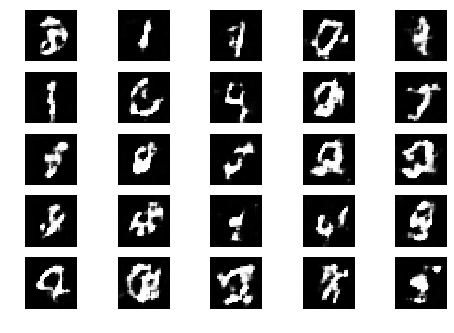

Epoch 2 Batch 205/375 [D loss: 0.787688, acc.: 46.88%] [G loss: 1.357919]
Epoch 2 Batch 206/375 [D loss: 0.833630, acc.: 46.88%] [G loss: 1.142611]
Epoch 2 Batch 207/375 [D loss: 0.730875, acc.: 50.00%] [G loss: 1.140942]
Epoch 2 Batch 208/375 [D loss: 0.681801, acc.: 62.50%] [G loss: 1.162307]
Epoch 2 Batch 209/375 [D loss: 0.657807, acc.: 59.38%] [G loss: 1.401795]
Epoch 2 Batch 210/375 [D loss: 0.681675, acc.: 62.50%] [G loss: 1.256313]
Epoch 2 Batch 211/375 [D loss: 0.657017, acc.: 62.50%] [G loss: 1.113271]
Epoch 2 Batch 212/375 [D loss: 0.569276, acc.: 68.75%] [G loss: 1.174046]
Epoch 2 Batch 213/375 [D loss: 0.525903, acc.: 71.88%] [G loss: 1.132132]
Epoch 2 Batch 214/375 [D loss: 0.630636, acc.: 62.50%] [G loss: 1.091460]
Epoch 2 Batch 215/375 [D loss: 0.687816, acc.: 56.25%] [G loss: 1.290353]
Epoch 2 Batch 216/375 [D loss: 0.691058, acc.: 59.38%] [G loss: 1.032177]
Epoch 2 Batch 217/375 [D loss: 0.613081, acc.: 68.75%] [G loss: 1.377914]
Epoch 2 Batch 218/375 [D loss: 0.72308

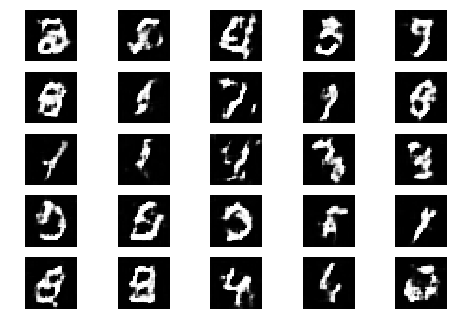

Epoch 2 Batch 301/375 [D loss: 0.616917, acc.: 71.88%] [G loss: 1.320402]
Epoch 2 Batch 302/375 [D loss: 0.826072, acc.: 50.00%] [G loss: 1.084278]
Epoch 2 Batch 303/375 [D loss: 0.569379, acc.: 65.62%] [G loss: 1.343148]


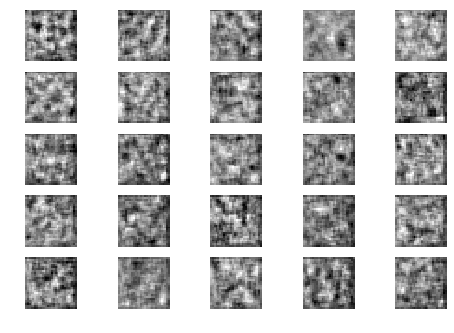

Epoch 2 Batch 304/375 [D loss: 0.483874, acc.: 81.25%] [G loss: 1.435277]
Epoch 2 Batch 305/375 [D loss: 0.662133, acc.: 68.75%] [G loss: 1.142493]
Epoch 2 Batch 306/375 [D loss: 0.619116, acc.: 68.75%] [G loss: 0.928570]


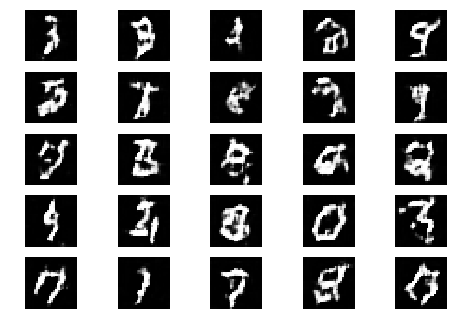

Epoch 2 Batch 307/375 [D loss: 0.736309, acc.: 56.25%] [G loss: 1.072071]
Epoch 2 Batch 308/375 [D loss: 0.623495, acc.: 62.50%] [G loss: 1.192543]
Epoch 2 Batch 309/375 [D loss: 0.675336, acc.: 71.88%] [G loss: 1.235630]
Epoch 2 Batch 310/375 [D loss: 0.742350, acc.: 53.12%] [G loss: 1.194097]
Epoch 2 Batch 311/375 [D loss: 0.631869, acc.: 65.62%] [G loss: 1.242995]
Epoch 2 Batch 312/375 [D loss: 0.627599, acc.: 65.62%] [G loss: 1.081455]
Epoch 2 Batch 313/375 [D loss: 0.627257, acc.: 59.38%] [G loss: 1.090351]
Epoch 2 Batch 314/375 [D loss: 0.638581, acc.: 62.50%] [G loss: 0.976091]
Epoch 2 Batch 315/375 [D loss: 0.753828, acc.: 46.88%] [G loss: 1.002771]
Epoch 2 Batch 316/375 [D loss: 0.535013, acc.: 75.00%] [G loss: 1.227782]
Epoch 2 Batch 317/375 [D loss: 0.683886, acc.: 56.25%] [G loss: 1.086629]
Epoch 2 Batch 318/375 [D loss: 0.616591, acc.: 62.50%] [G loss: 1.096755]
Epoch 2 Batch 319/375 [D loss: 0.547820, acc.: 65.62%] [G loss: 1.088215]
Epoch 2 Batch 320/375 [D loss: 0.61991

In [18]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

Number of examples:  12000.0
Number of Batches:  375
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)
Epoch 0 Batch 0/375 [D loss: 0.419964, acc.: 84.38%] [G loss: 0.926327]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


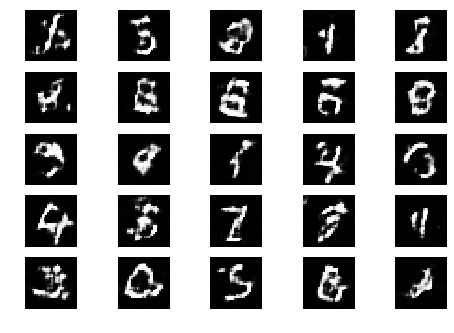

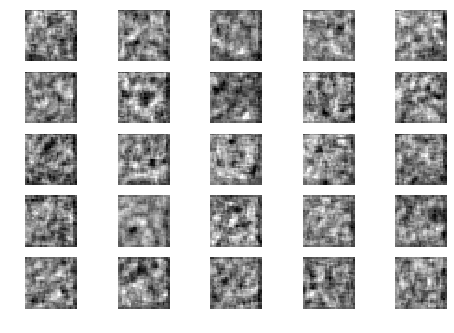

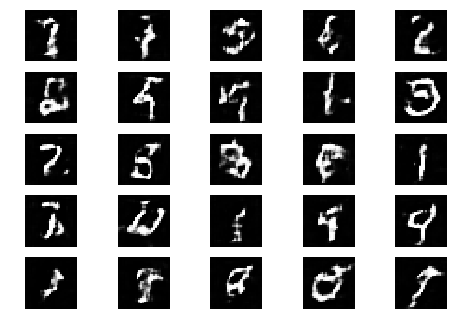

Epoch 0 Batch 1/375 [D loss: 0.200815, acc.: 90.62%] [G loss: 0.442982]
Epoch 0 Batch 2/375 [D loss: 0.112624, acc.: 96.88%] [G loss: 0.304587]
Epoch 0 Batch 3/375 [D loss: 0.101362, acc.: 100.00%] [G loss: 0.225316]
Epoch 0 Batch 4/375 [D loss: 0.039198, acc.: 100.00%] [G loss: 0.218780]
Epoch 0 Batch 5/375 [D loss: 0.062388, acc.: 100.00%] [G loss: 0.140545]
Epoch 0 Batch 6/375 [D loss: 0.041297, acc.: 100.00%] [G loss: 0.130575]
Epoch 0 Batch 7/375 [D loss: 0.033236, acc.: 100.00%] [G loss: 0.167553]
Epoch 0 Batch 8/375 [D loss: 0.036586, acc.: 100.00%] [G loss: 0.096871]
Epoch 0 Batch 9/375 [D loss: 0.025894, acc.: 100.00%] [G loss: 0.079394]
Epoch 0 Batch 10/375 [D loss: 0.033404, acc.: 100.00%] [G loss: 0.111170]
Epoch 0 Batch 11/375 [D loss: 0.028727, acc.: 100.00%] [G loss: 0.081040]
Epoch 0 Batch 12/375 [D loss: 0.014251, acc.: 100.00%] [G loss: 0.063868]
Epoch 0 Batch 13/375 [D loss: 0.018015, acc.: 100.00%] [G loss: 0.075836]
Epoch 0 Batch 14/375 [D loss: 0.028335, acc.: 100

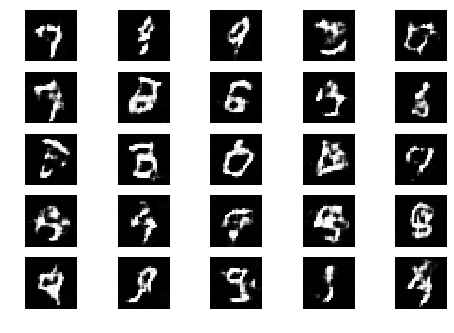

Epoch 0 Batch 101/375 [D loss: 0.003582, acc.: 100.00%] [G loss: 0.007915]


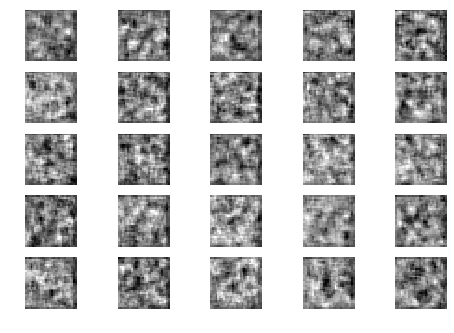

Epoch 0 Batch 102/375 [D loss: 0.001764, acc.: 100.00%] [G loss: 0.010355]


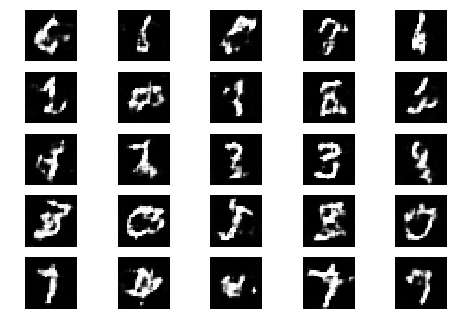

Epoch 0 Batch 103/375 [D loss: 0.001925, acc.: 100.00%] [G loss: 0.005859]
Epoch 0 Batch 104/375 [D loss: 0.002114, acc.: 100.00%] [G loss: 0.013388]
Epoch 0 Batch 105/375 [D loss: 0.002901, acc.: 100.00%] [G loss: 0.007056]
Epoch 0 Batch 106/375 [D loss: 0.003097, acc.: 100.00%] [G loss: 0.011809]
Epoch 0 Batch 107/375 [D loss: 0.002712, acc.: 100.00%] [G loss: 0.009463]
Epoch 0 Batch 108/375 [D loss: 0.003262, acc.: 100.00%] [G loss: 0.005542]
Epoch 0 Batch 109/375 [D loss: 0.003088, acc.: 100.00%] [G loss: 0.007783]
Epoch 0 Batch 110/375 [D loss: 0.003190, acc.: 100.00%] [G loss: 0.006157]
Epoch 0 Batch 111/375 [D loss: 0.002561, acc.: 100.00%] [G loss: 0.006005]
Epoch 0 Batch 112/375 [D loss: 0.002205, acc.: 100.00%] [G loss: 0.007393]
Epoch 0 Batch 113/375 [D loss: 0.002375, acc.: 100.00%] [G loss: 0.011103]
Epoch 0 Batch 114/375 [D loss: 0.002382, acc.: 100.00%] [G loss: 0.004610]
Epoch 0 Batch 115/375 [D loss: 0.002628, acc.: 100.00%] [G loss: 0.007754]
Epoch 0 Batch 116/375 [D 

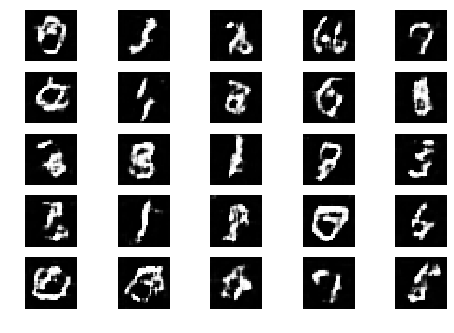

Epoch 0 Batch 201/375 [D loss: 0.001045, acc.: 100.00%] [G loss: 0.002868]
Epoch 0 Batch 202/375 [D loss: 0.001743, acc.: 100.00%] [G loss: 0.003311]


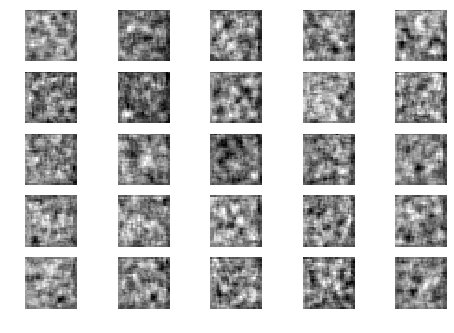

Epoch 0 Batch 203/375 [D loss: 0.001511, acc.: 100.00%] [G loss: 0.002106]
Epoch 0 Batch 204/375 [D loss: 0.001355, acc.: 100.00%] [G loss: 0.002573]


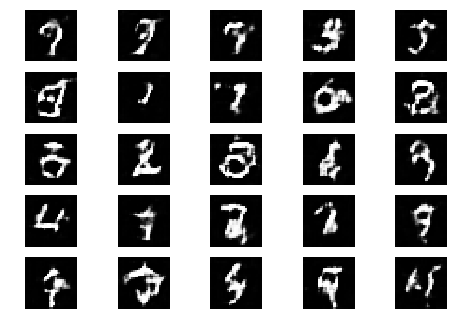

Epoch 0 Batch 205/375 [D loss: 0.001590, acc.: 100.00%] [G loss: 0.002877]
Epoch 0 Batch 206/375 [D loss: 0.001242, acc.: 100.00%] [G loss: 0.002739]
Epoch 0 Batch 207/375 [D loss: 0.001075, acc.: 100.00%] [G loss: 0.002796]
Epoch 0 Batch 208/375 [D loss: 0.001001, acc.: 100.00%] [G loss: 0.003097]
Epoch 0 Batch 209/375 [D loss: 0.001438, acc.: 100.00%] [G loss: 0.002267]
Epoch 0 Batch 210/375 [D loss: 0.001558, acc.: 100.00%] [G loss: 0.003961]
Epoch 0 Batch 211/375 [D loss: 0.002588, acc.: 100.00%] [G loss: 0.003358]
Epoch 0 Batch 212/375 [D loss: 0.001135, acc.: 100.00%] [G loss: 0.004530]
Epoch 0 Batch 213/375 [D loss: 0.001359, acc.: 100.00%] [G loss: 0.002376]
Epoch 0 Batch 214/375 [D loss: 0.001341, acc.: 100.00%] [G loss: 0.002618]
Epoch 0 Batch 215/375 [D loss: 0.000879, acc.: 100.00%] [G loss: 0.003680]
Epoch 0 Batch 216/375 [D loss: 0.001397, acc.: 100.00%] [G loss: 0.002284]
Epoch 0 Batch 217/375 [D loss: 0.001002, acc.: 100.00%] [G loss: 0.002516]
Epoch 0 Batch 218/375 [D 

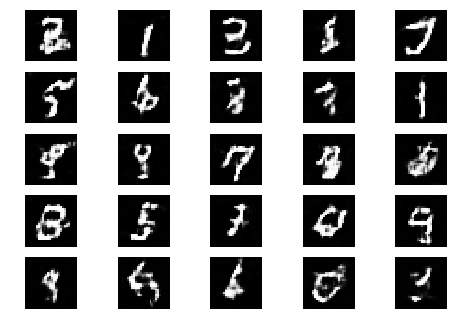

Epoch 0 Batch 301/375 [D loss: 0.000885, acc.: 100.00%] [G loss: 0.002134]
Epoch 0 Batch 302/375 [D loss: 0.000766, acc.: 100.00%] [G loss: 0.001241]
Epoch 0 Batch 303/375 [D loss: 0.000621, acc.: 100.00%] [G loss: 0.002830]


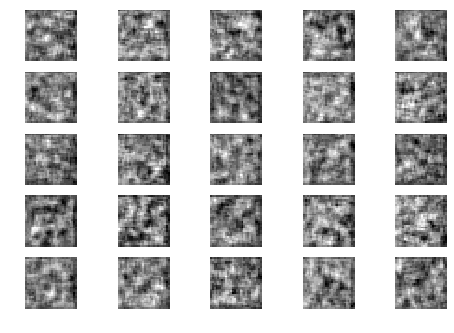

Epoch 0 Batch 304/375 [D loss: 0.000848, acc.: 100.00%] [G loss: 0.002013]
Epoch 0 Batch 305/375 [D loss: 0.000728, acc.: 100.00%] [G loss: 0.001333]
Epoch 0 Batch 306/375 [D loss: 0.001242, acc.: 100.00%] [G loss: 0.001740]


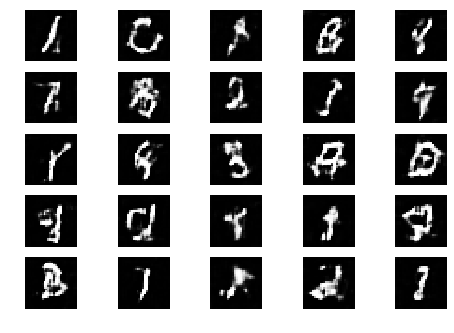

Epoch 0 Batch 307/375 [D loss: 0.000708, acc.: 100.00%] [G loss: 0.001470]
Epoch 0 Batch 308/375 [D loss: 0.000780, acc.: 100.00%] [G loss: 0.001424]
Epoch 0 Batch 309/375 [D loss: 0.000704, acc.: 100.00%] [G loss: 0.002260]
Epoch 0 Batch 310/375 [D loss: 0.000867, acc.: 100.00%] [G loss: 0.002222]
Epoch 0 Batch 311/375 [D loss: 0.000993, acc.: 100.00%] [G loss: 0.002371]
Epoch 0 Batch 312/375 [D loss: 0.000580, acc.: 100.00%] [G loss: 0.001828]
Epoch 0 Batch 313/375 [D loss: 0.000524, acc.: 100.00%] [G loss: 0.001255]
Epoch 0 Batch 314/375 [D loss: 0.000752, acc.: 100.00%] [G loss: 0.002148]
Epoch 0 Batch 315/375 [D loss: 0.000669, acc.: 100.00%] [G loss: 0.002511]
Epoch 0 Batch 316/375 [D loss: 0.000645, acc.: 100.00%] [G loss: 0.001698]
Epoch 0 Batch 317/375 [D loss: 0.001140, acc.: 100.00%] [G loss: 0.001825]
Epoch 0 Batch 318/375 [D loss: 0.001010, acc.: 100.00%] [G loss: 0.001092]
Epoch 0 Batch 319/375 [D loss: 0.000759, acc.: 100.00%] [G loss: 0.002764]
Epoch 0 Batch 320/375 [D 

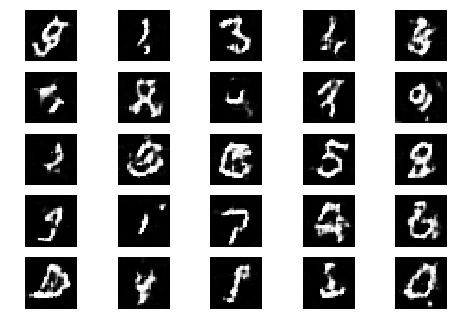

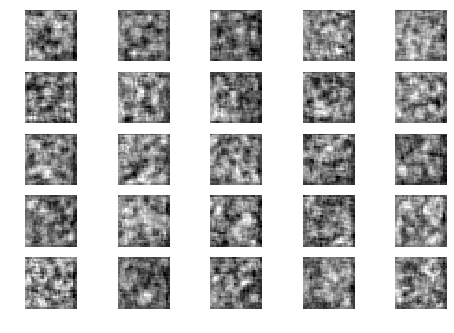

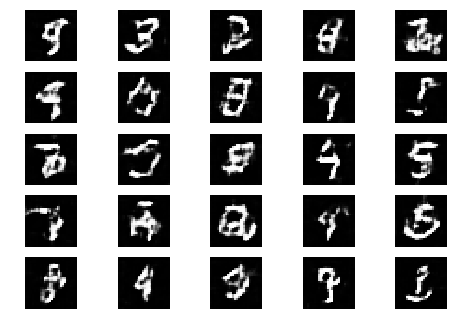

Epoch 1 Batch 1/375 [D loss: 0.000504, acc.: 100.00%] [G loss: 0.002581]
Epoch 1 Batch 2/375 [D loss: 0.000929, acc.: 100.00%] [G loss: 0.001227]
Epoch 1 Batch 3/375 [D loss: 0.001045, acc.: 100.00%] [G loss: 0.000967]
Epoch 1 Batch 4/375 [D loss: 0.000591, acc.: 100.00%] [G loss: 0.001249]
Epoch 1 Batch 5/375 [D loss: 0.000588, acc.: 100.00%] [G loss: 0.001073]
Epoch 1 Batch 6/375 [D loss: 0.000659, acc.: 100.00%] [G loss: 0.001139]
Epoch 1 Batch 7/375 [D loss: 0.000717, acc.: 100.00%] [G loss: 0.001817]
Epoch 1 Batch 8/375 [D loss: 0.000513, acc.: 100.00%] [G loss: 0.000810]
Epoch 1 Batch 9/375 [D loss: 0.000724, acc.: 100.00%] [G loss: 0.001501]
Epoch 1 Batch 10/375 [D loss: 0.000569, acc.: 100.00%] [G loss: 0.001011]
Epoch 1 Batch 11/375 [D loss: 0.000687, acc.: 100.00%] [G loss: 0.001097]
Epoch 1 Batch 12/375 [D loss: 0.000570, acc.: 100.00%] [G loss: 0.001460]
Epoch 1 Batch 13/375 [D loss: 0.000614, acc.: 100.00%] [G loss: 0.001592]
Epoch 1 Batch 14/375 [D loss: 0.000471, acc.: 1

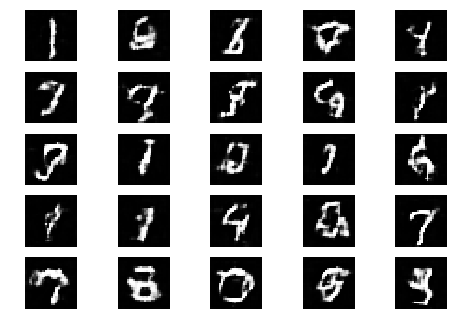

Epoch 1 Batch 101/375 [D loss: 0.000420, acc.: 100.00%] [G loss: 0.001051]


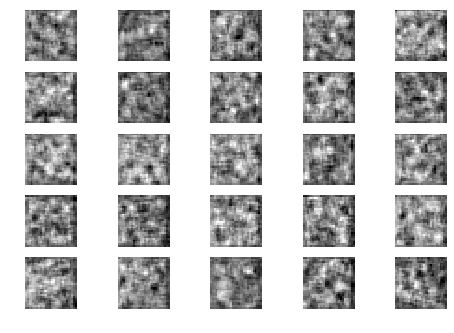

Epoch 1 Batch 102/375 [D loss: 0.000303, acc.: 100.00%] [G loss: 0.000902]


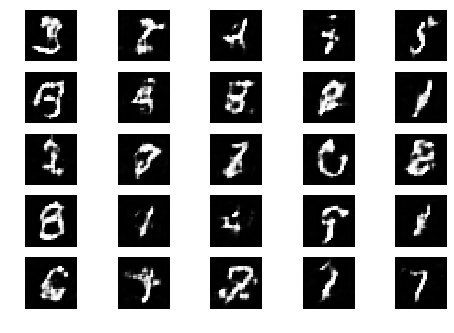

Epoch 1 Batch 103/375 [D loss: 0.000258, acc.: 100.00%] [G loss: 0.001106]
Epoch 1 Batch 104/375 [D loss: 0.000284, acc.: 100.00%] [G loss: 0.000978]
Epoch 1 Batch 105/375 [D loss: 0.000340, acc.: 100.00%] [G loss: 0.000995]
Epoch 1 Batch 106/375 [D loss: 0.000385, acc.: 100.00%] [G loss: 0.000681]
Epoch 1 Batch 107/375 [D loss: 0.000438, acc.: 100.00%] [G loss: 0.000759]
Epoch 1 Batch 108/375 [D loss: 0.000389, acc.: 100.00%] [G loss: 0.000808]
Epoch 1 Batch 109/375 [D loss: 0.000440, acc.: 100.00%] [G loss: 0.001452]
Epoch 1 Batch 110/375 [D loss: 0.000480, acc.: 100.00%] [G loss: 0.001329]
Epoch 1 Batch 111/375 [D loss: 0.000390, acc.: 100.00%] [G loss: 0.001032]
Epoch 1 Batch 112/375 [D loss: 0.000276, acc.: 100.00%] [G loss: 0.000734]
Epoch 1 Batch 113/375 [D loss: 0.000698, acc.: 100.00%] [G loss: 0.001182]
Epoch 1 Batch 114/375 [D loss: 0.000481, acc.: 100.00%] [G loss: 0.000969]
Epoch 1 Batch 115/375 [D loss: 0.000552, acc.: 100.00%] [G loss: 0.000808]
Epoch 1 Batch 116/375 [D 

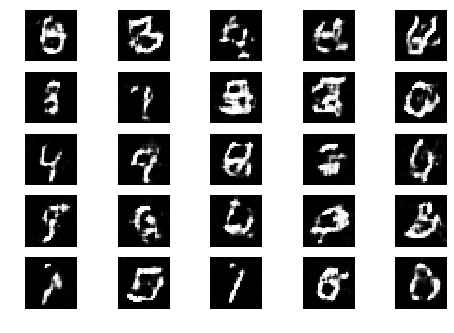

Epoch 1 Batch 201/375 [D loss: 0.000298, acc.: 100.00%] [G loss: 0.000740]
Epoch 1 Batch 202/375 [D loss: 0.000471, acc.: 100.00%] [G loss: 0.000677]


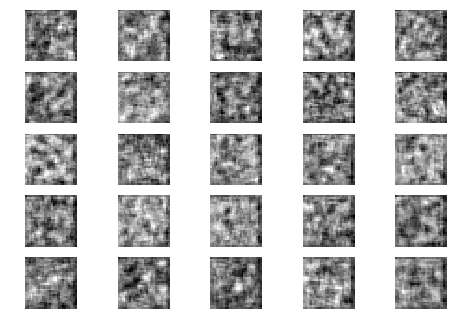

Epoch 1 Batch 203/375 [D loss: 0.000352, acc.: 100.00%] [G loss: 0.000585]
Epoch 1 Batch 204/375 [D loss: 0.000356, acc.: 100.00%] [G loss: 0.000552]


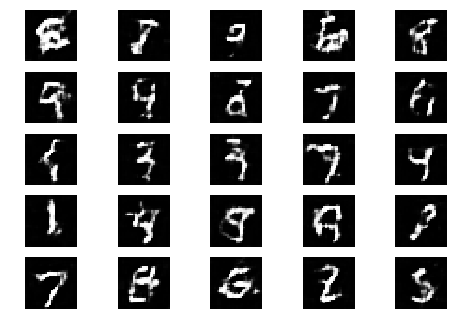

Epoch 1 Batch 205/375 [D loss: 0.000302, acc.: 100.00%] [G loss: 0.000508]
Epoch 1 Batch 206/375 [D loss: 0.000406, acc.: 100.00%] [G loss: 0.000934]
Epoch 1 Batch 207/375 [D loss: 0.000201, acc.: 100.00%] [G loss: 0.000482]
Epoch 1 Batch 208/375 [D loss: 0.000264, acc.: 100.00%] [G loss: 0.000566]
Epoch 1 Batch 209/375 [D loss: 0.000498, acc.: 100.00%] [G loss: 0.000883]
Epoch 1 Batch 210/375 [D loss: 0.000337, acc.: 100.00%] [G loss: 0.000653]
Epoch 1 Batch 211/375 [D loss: 0.000317, acc.: 100.00%] [G loss: 0.001121]
Epoch 1 Batch 212/375 [D loss: 0.000264, acc.: 100.00%] [G loss: 0.000948]
Epoch 1 Batch 213/375 [D loss: 0.000408, acc.: 100.00%] [G loss: 0.000798]
Epoch 1 Batch 214/375 [D loss: 0.000598, acc.: 100.00%] [G loss: 0.000623]
Epoch 1 Batch 215/375 [D loss: 0.000290, acc.: 100.00%] [G loss: 0.001016]
Epoch 1 Batch 216/375 [D loss: 0.000344, acc.: 100.00%] [G loss: 0.000728]
Epoch 1 Batch 217/375 [D loss: 0.000344, acc.: 100.00%] [G loss: 0.000623]
Epoch 1 Batch 218/375 [D 

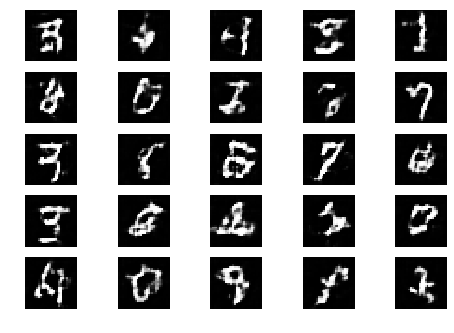

Epoch 1 Batch 301/375 [D loss: 0.000265, acc.: 100.00%] [G loss: 0.000804]
Epoch 1 Batch 302/375 [D loss: 0.000251, acc.: 100.00%] [G loss: 0.000471]
Epoch 1 Batch 303/375 [D loss: 0.000192, acc.: 100.00%] [G loss: 0.000447]


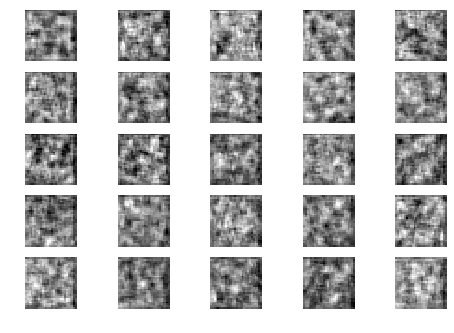

Epoch 1 Batch 304/375 [D loss: 0.000234, acc.: 100.00%] [G loss: 0.000708]
Epoch 1 Batch 305/375 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.000591]
Epoch 1 Batch 306/375 [D loss: 0.000199, acc.: 100.00%] [G loss: 0.000639]


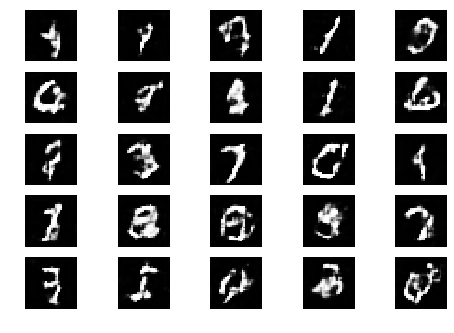

Epoch 1 Batch 307/375 [D loss: 0.000289, acc.: 100.00%] [G loss: 0.000679]
Epoch 1 Batch 308/375 [D loss: 0.000277, acc.: 100.00%] [G loss: 0.000599]
Epoch 1 Batch 309/375 [D loss: 0.000237, acc.: 100.00%] [G loss: 0.000592]
Epoch 1 Batch 310/375 [D loss: 0.000314, acc.: 100.00%] [G loss: 0.000648]
Epoch 1 Batch 311/375 [D loss: 0.000402, acc.: 100.00%] [G loss: 0.000423]
Epoch 1 Batch 312/375 [D loss: 0.000278, acc.: 100.00%] [G loss: 0.000623]
Epoch 1 Batch 313/375 [D loss: 0.000702, acc.: 100.00%] [G loss: 0.000527]
Epoch 1 Batch 314/375 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.000449]
Epoch 1 Batch 315/375 [D loss: 0.000220, acc.: 100.00%] [G loss: 0.000595]
Epoch 1 Batch 316/375 [D loss: 0.000253, acc.: 100.00%] [G loss: 0.000521]
Epoch 1 Batch 317/375 [D loss: 0.000177, acc.: 100.00%] [G loss: 0.000539]
Epoch 1 Batch 318/375 [D loss: 0.000209, acc.: 100.00%] [G loss: 0.000472]
Epoch 1 Batch 319/375 [D loss: 0.000230, acc.: 100.00%] [G loss: 0.000619]
Epoch 1 Batch 320/375 [D 

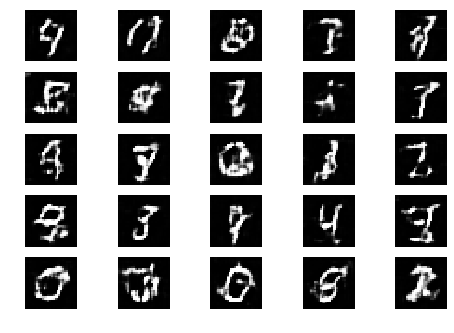

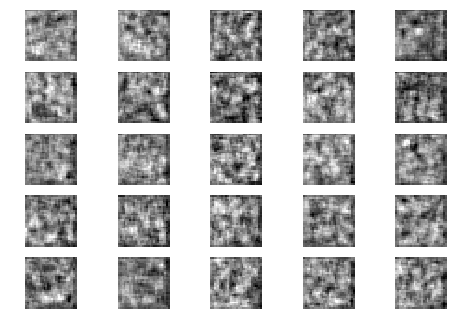

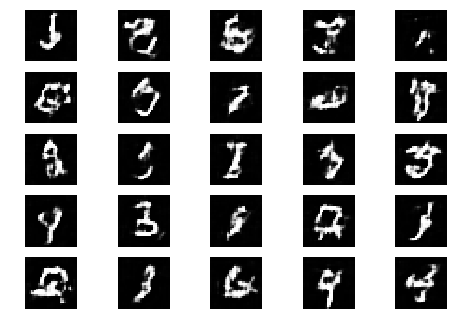

Epoch 2 Batch 1/375 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.000411]
Epoch 2 Batch 2/375 [D loss: 0.000179, acc.: 100.00%] [G loss: 0.000412]
Epoch 2 Batch 3/375 [D loss: 0.000314, acc.: 100.00%] [G loss: 0.000379]
Epoch 2 Batch 4/375 [D loss: 0.000281, acc.: 100.00%] [G loss: 0.000482]
Epoch 2 Batch 5/375 [D loss: 0.000241, acc.: 100.00%] [G loss: 0.000705]
Epoch 2 Batch 6/375 [D loss: 0.000288, acc.: 100.00%] [G loss: 0.000369]
Epoch 2 Batch 7/375 [D loss: 0.000403, acc.: 100.00%] [G loss: 0.000382]
Epoch 2 Batch 8/375 [D loss: 0.000137, acc.: 100.00%] [G loss: 0.000572]
Epoch 2 Batch 9/375 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.000535]
Epoch 2 Batch 10/375 [D loss: 0.000215, acc.: 100.00%] [G loss: 0.000443]
Epoch 2 Batch 11/375 [D loss: 0.000288, acc.: 100.00%] [G loss: 0.000441]
Epoch 2 Batch 12/375 [D loss: 0.000294, acc.: 100.00%] [G loss: 0.000762]
Epoch 2 Batch 13/375 [D loss: 0.000266, acc.: 100.00%] [G loss: 0.000325]
Epoch 2 Batch 14/375 [D loss: 0.000379, acc.: 1

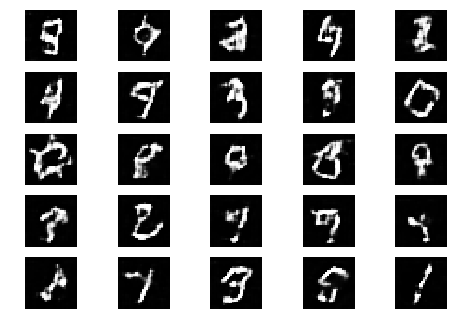

Epoch 2 Batch 101/375 [D loss: 0.000258, acc.: 100.00%] [G loss: 0.000263]


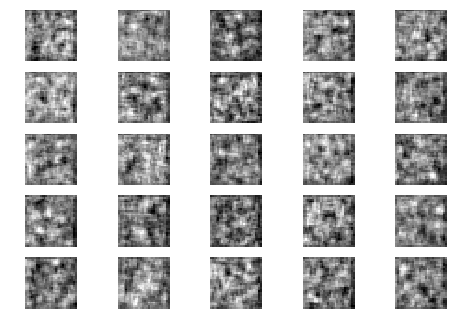

Epoch 2 Batch 102/375 [D loss: 0.000180, acc.: 100.00%] [G loss: 0.000357]


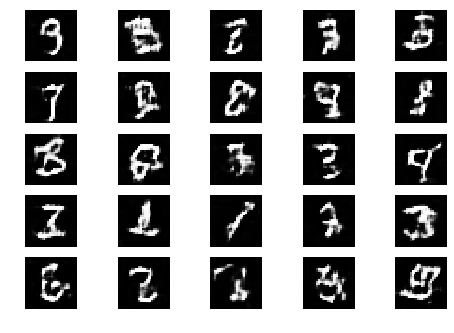

Epoch 2 Batch 103/375 [D loss: 0.000122, acc.: 100.00%] [G loss: 0.000365]
Epoch 2 Batch 104/375 [D loss: 0.000165, acc.: 100.00%] [G loss: 0.000262]
Epoch 2 Batch 105/375 [D loss: 0.000163, acc.: 100.00%] [G loss: 0.000531]
Epoch 2 Batch 106/375 [D loss: 0.000208, acc.: 100.00%] [G loss: 0.000270]
Epoch 2 Batch 107/375 [D loss: 0.000229, acc.: 100.00%] [G loss: 0.000445]
Epoch 2 Batch 108/375 [D loss: 0.000287, acc.: 100.00%] [G loss: 0.000393]
Epoch 2 Batch 109/375 [D loss: 0.000187, acc.: 100.00%] [G loss: 0.000287]
Epoch 2 Batch 110/375 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.000279]
Epoch 2 Batch 111/375 [D loss: 0.000149, acc.: 100.00%] [G loss: 0.000448]
Epoch 2 Batch 112/375 [D loss: 0.000225, acc.: 100.00%] [G loss: 0.000500]
Epoch 2 Batch 113/375 [D loss: 0.000189, acc.: 100.00%] [G loss: 0.000524]
Epoch 2 Batch 114/375 [D loss: 0.000082, acc.: 100.00%] [G loss: 0.000667]
Epoch 2 Batch 115/375 [D loss: 0.000152, acc.: 100.00%] [G loss: 0.000352]
Epoch 2 Batch 116/375 [D 

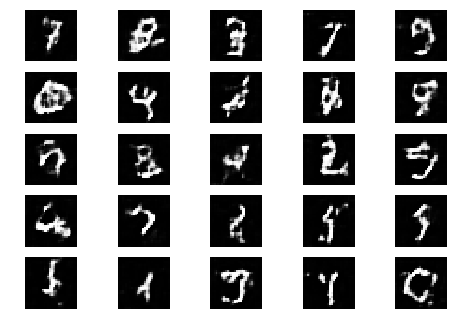

Epoch 2 Batch 201/375 [D loss: 0.000134, acc.: 100.00%] [G loss: 0.000304]
Epoch 2 Batch 202/375 [D loss: 0.000261, acc.: 100.00%] [G loss: 0.000294]


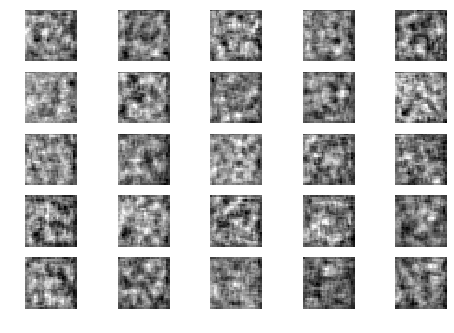

Epoch 2 Batch 203/375 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.000196]
Epoch 2 Batch 204/375 [D loss: 0.000115, acc.: 100.00%] [G loss: 0.000329]


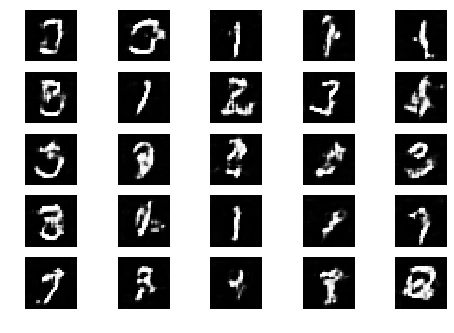

Epoch 2 Batch 205/375 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.000243]
Epoch 2 Batch 206/375 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.000226]
Epoch 2 Batch 207/375 [D loss: 0.000159, acc.: 100.00%] [G loss: 0.000205]
Epoch 2 Batch 208/375 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.000220]
Epoch 2 Batch 209/375 [D loss: 0.000175, acc.: 100.00%] [G loss: 0.000266]
Epoch 2 Batch 210/375 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.000281]
Epoch 2 Batch 211/375 [D loss: 0.000215, acc.: 100.00%] [G loss: 0.000232]
Epoch 2 Batch 212/375 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.000233]
Epoch 2 Batch 213/375 [D loss: 0.000210, acc.: 100.00%] [G loss: 0.000468]
Epoch 2 Batch 214/375 [D loss: 0.000221, acc.: 100.00%] [G loss: 0.000294]
Epoch 2 Batch 215/375 [D loss: 0.000139, acc.: 100.00%] [G loss: 0.000313]
Epoch 2 Batch 216/375 [D loss: 0.000133, acc.: 100.00%] [G loss: 0.000474]
Epoch 2 Batch 217/375 [D loss: 0.000131, acc.: 100.00%] [G loss: 0.000200]
Epoch 2 Batch 218/375 [D 

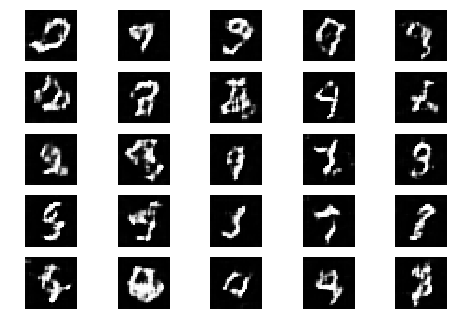

Epoch 2 Batch 301/375 [D loss: 0.000130, acc.: 100.00%] [G loss: 0.000289]
Epoch 2 Batch 302/375 [D loss: 0.000185, acc.: 100.00%] [G loss: 0.000377]
Epoch 2 Batch 303/375 [D loss: 0.000074, acc.: 100.00%] [G loss: 0.000215]


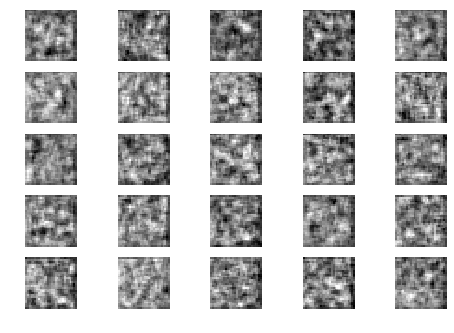

Epoch 2 Batch 304/375 [D loss: 0.000165, acc.: 100.00%] [G loss: 0.000216]
Epoch 2 Batch 305/375 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.000292]
Epoch 2 Batch 306/375 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.000194]


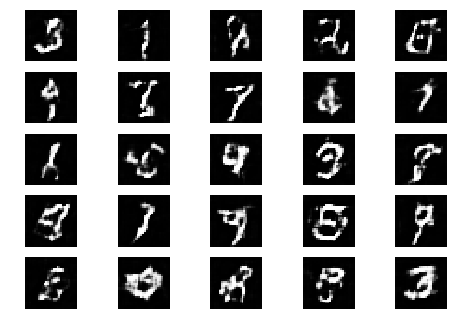

Epoch 2 Batch 307/375 [D loss: 0.000162, acc.: 100.00%] [G loss: 0.000280]
Epoch 2 Batch 308/375 [D loss: 0.000084, acc.: 100.00%] [G loss: 0.000226]
Epoch 2 Batch 309/375 [D loss: 0.000095, acc.: 100.00%] [G loss: 0.000233]
Epoch 2 Batch 310/375 [D loss: 0.000224, acc.: 100.00%] [G loss: 0.000221]
Epoch 2 Batch 311/375 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.000327]
Epoch 2 Batch 312/375 [D loss: 0.000118, acc.: 100.00%] [G loss: 0.000222]
Epoch 2 Batch 313/375 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.000159]
Epoch 2 Batch 314/375 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.000285]
Epoch 2 Batch 315/375 [D loss: 0.000207, acc.: 100.00%] [G loss: 0.000243]
Epoch 2 Batch 316/375 [D loss: 0.000117, acc.: 100.00%] [G loss: 0.000243]
Epoch 2 Batch 317/375 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.000290]
Epoch 2 Batch 318/375 [D loss: 0.000196, acc.: 100.00%] [G loss: 0.000271]
Epoch 2 Batch 319/375 [D loss: 0.000137, acc.: 100.00%] [G loss: 0.000246]
Epoch 2 Batch 320/375 [D 

In [19]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
    generator1.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')

In [0]:
##files.download('generator1.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

